
# The baseline query + purpose and target

In [1]:
from openai import OpenAI
import pandas as pd

client = OpenAI()
df = pd.read_csv('verbs.csv')

def translate_verb(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [
            {"role": "system", "content": "You are an expert in Moroccan Darija dialect and in translating Darija to English." +           
            "Translate the provided Moroccan Darija language verbs into English using word-by-word translation." + 
            "Please fulfill the following conditions when translating:"+
            "The output must not be an infinitive verb. No explanations are needed in the output"+
            "Purpose of the translation: To study the accuracy of LLMs on Low resource languages, particularly Darija." + 
            "Target audience: Computational linguists" 
            },
            {
            "role": "user", 
            "content":  f'{verb}' 
            }
        ],        
        temperature=0  # Deterministic responses
    )
    return completion.choices[0].message.content

# Apply the translation function to the 'darija_ar' column
df['english_translation'] = df['darija_ar'].apply(translate_verb)

print(df)

           n1       n2     n3       n4       n5    n6 darija_ar         eng  \
0         kla      NaN    NaN      NaN      NaN   NaN       كلا         eat   
1        chrb    chreb    NaN      NaN      NaN   NaN       شرب       drink   
2       dkhel     dkhl  dkhal     d5el      d5l  d5al       دخل       enter   
3        khrj    khraj  khrej      5rj     5raj  5rej       خرج      go out   
4        fhem      fhm   fham     f8em      f8m  f8am       فهم  understand   
...       ...      ...    ...      ...      ...   ...       ...         ...   
1027   bllegh      NaN    NaN      NaN      NaN   NaN      بلّغ      notify   
1028      Tfa      NaN    NaN      NaN      NaN   NaN       طفا    turn off   
1029    ryye7    riye7   ryy7      NaN      NaN   NaN      ريّح    sit down   
1030    ghech  ghechch   ghch    ghach      NaN   NaN        غش       cheat   
1031  9chcher    9cher  qcher  qchcher  9chchar   NaN      قشّر        peel   

     english_translation  
0                    Eat

In [2]:
from nltk.corpus import wordnet as wn

dataset = df.copy()

columns_to_delete = ['n2', 'n3', 'n4', 'n5', 'n6']
dataset.drop(columns=columns_to_delete, inplace=True)

eng = dataset['eng']
transl = dataset['english_translation']
transl = [verb.replace(" ", "_") for verb in transl]
eng = [verb.replace(" ", "_") for verb in eng]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score

def evaluate_pairs(threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results
results = evaluate_pairs()
similarities = [item[2] for item in results]

dataset['similarity'] = similarities
mean_similarity = dataset['similarity'].mean()


print(f'Mean value of similarities is: {mean_similarity}')
dataset.describe()



Mean value of similarities is: 0.5407272233580374


,similarity
count,1032.000000
mean,0.540727
std,0.405227
min,0.000000
25%,0.200000
50%,0.500000
75%,1.000000
max,1.000000


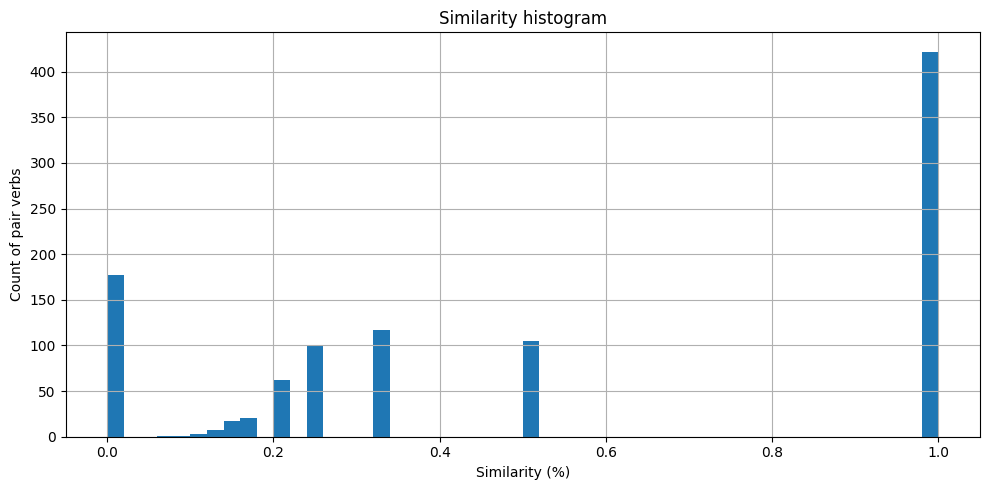

In [3]:
import matplotlib.pyplot as plt

dataset.hist(bins=50, figsize=(10,5))
plt.xlabel('Similarity (%)')
plt.ylabel('Count of pair verbs')
plt.title('Similarity histogram')
plt.tight_layout()
plt.grid(True)
plt.show()


In [5]:
zero_df = dataset[dataset['similarity'] == 0]
print(zero_df)


          n1 darija_ar       eng english_translation  similarity
17       3am       عام      swim                Year         0.0
20       slt       سلت  take off             I asked         0.0
27     tsalm     تسالم    salute           You peace         0.0
51      khss       خسّ    should                Lose         0.0
54      khbr       خبر      tell                News         0.0
...      ...       ...       ...                 ...         ...
1013  nkharT     نخارط    adhere            We carve         0.0
1015  sted3a     ستدعا    summon       You will call         0.0
1021   tsme3      تسمع     sound            you hear         0.0
1022   n99eT      نقّط     grade              we dot         0.0
1025   jaaza      جازا     award               Came.         0.0

[177 rows x 5 columns]
